<a href="https://colab.research.google.com/github/eanchiquep/Machine_Learning_Google_Lab/blob/master/Codigo_Canair_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

La base de datos de canairo se encuentra estructurada en influxdb, leyendo la documentación es necesario instalar la libreria influxdb para poder comunicarse con el servidor y poder extraer los datos de los mismos. 

In [ ]:
pip install influxdb

Importamos las diferentes librerias para traer las bases de dato desde canair.io y poder realizar la manipulación y transformación de los mismos.

In [ ]:
from influxdb import InfluxDBClient
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

A continuación realizamos la conección y la extracción de los datos de canair.io, a modo de ejemplo se utilizarán los datos de la estación de monitoreo "PM25_Berlin_CanAirIO_v2".

In [ ]:
client = InfluxDBClient(host='influxdb.canair.io', port=8086, database='canairio')
#PM2.5_BOG_FON_Hayuelos_E01
#result = client.query(" select lat,lng,pm10,pm25,spd  from PM25_Berlin_CanAirIO_v2  WHERE time >= now() - 365d  ", database='canairio')
# podemos indicar el tipo de parametro del dataset y la estación
#"PM2.5_BOG_FON_Hayuelos_E01"
#[PM2.5_BOG_SFE_LaMacarena_E01, PM2.5_BOG_ENG_Tibabuyes_E08, PM2.5_BOG_ENG_EstacionFerias,PM2.5_BOG_CHA_Virrey_E01,PM2.5_BOG_SFE_LaMacarena_E01,PM2.5_BOG_TEU_Salitre_E02,PM2.5_BOG_FON_Hayuelos_E01,PM2.5_BOG_PAR_Pradera_E01,PM2.5_BOG_MAR_EduardoSantos_E01,PM2.5_BOG_AN_CJardin_E02,PM2.5_CUN_SUA_Satelite_E03]

 
result =  client.query('select pm10, pm25, spd, tmp from "PM2.5_BOG_ENG_Tibabuyes_E08" WHERE time >= now() - 365d')

Almacenamos nuestros datos en un dataframe:

In [ ]:
dataset = result.raw['series'][0]
df = pd.DataFrame(dataset['values'], columns= dataset['columns'])

A continuación realizamos la eliminación de datos nulos:

In [ ]:
df.dropna()

,time,pm10,pm25,spd,tmp
0,2020-04-18T00:59:29.568539Z,25.0,24.0,0.0,20.000000
1,2020-04-18T01:00:30.498400Z,25.0,24.0,0.0,20.100000
2,2020-04-18T01:01:31.621980Z,26.0,25.0,0.0,20.100000
3,2020-04-18T01:02:31.940529Z,26.0,24.0,0.0,20.100000
4,2020-04-18T01:03:32.157374Z,26.0,25.0,0.0,20.200001
...,...,...,...,...,...
486171,2021-04-18T00:53:52.051650Z,5.0,4.0,0.0,23.000000
486172,2021-04-18T00:54:52.168657Z,5.0,4.0,0.0,23.000000
486173,2021-04-18T00:55:52.985447Z,5.0,4.0,0.0,23.000000
486174,2021-04-18T00:56:53.096290Z,5.0,4.0,0.0,23.000000


Con el siguiente codigo, transformamos la columna time en tipo datetime:

In [ ]:
df['time'] = pd.to_datetime(df['time'])

mask=df['pm10'] > df['pm10'].quantile(0.75) + 1.5 * (df['pm10'].quantile(0.75) - df['pm10'].quantile(0.25)) 
df = df[mask]

Ahora definimos una función para realizar el calculo del ICA:

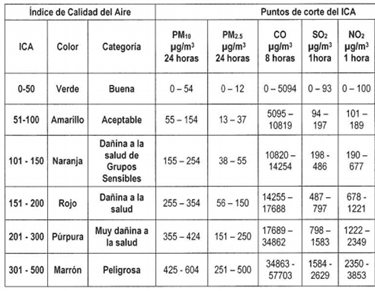

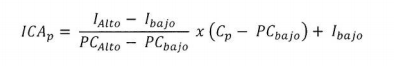

In [ ]:
class IcaClass:

  def __init__(self):
    self.constructor = "Emanuel_Anchique_Pautt"

  def ICA(self,Cp,tipo):
    """Función ICA devuelve el calculo del ICA para un solo valor, no recibe arreglos.
       Cp = Es un valor flotante o entero, no puede ser un arreglo.
       tipo = es un string y solo puede tomar los siguientes valores 'pm10','pm2.5','CO','SO2','NO2'
    '"""
    #redondeamos la concentración
    round(Cp)
    #Definimos las diferentes variables
    tc = ['pm10','pm2.5','CO','SO2','NO2']
    ia = [50,100,150,200,300,500]
    ib = [0,51,101,151,201,301]
    pca_pm10 = [54,154,254,354,424,604]
    pcb_pm10 = [0,55,155,255,355,425]
    pca_pm25 = [12,37,55,150,250,500]
    pcb_pm25 = [0,13,38,56,151,251]
    pca_CO = [5094,10819,14254,17688,34862,57703]
    pcb_CO = [0,5095,10820,14255,17689,34863]
    pca_SO2 = [93,197,486,797,1583,2629]
    pcb_SO2 = [0,94,198,487,798,1584]
    pca_NO2 = [100,189,677,1221,2349,3853]
    pcb_NO2 = [0,101,190,678,1222,2350]

    #Definimos un arreglo para almacenar el resultado
    resultado = []

    #CALCULOS PARA VALORES DENTRO DE LOS RANGOS
    for i in range(6):
      if (tipo == 'pm10' and Cp >= pcb_pm10[i]) and (tipo == 'pm10' and Cp <= pca_pm10[i]) :
        ICA = round(((ia[i] - ib[i]) / (pca_pm10[i] - pcb_pm10[i])) * (Cp - pcb_pm10[i]) + ib[i])
        resultado.append(ICA)

      if (tipo == 'pm2.5' and Cp >= pcb_pm25[i]) and (tipo == 'pm2.5'  and Cp <= pca_pm25[i]) :
        ICA = round(((ia[i] - ib[i]) / (pca_pm25[i] - pcb_pm25[i])) * (Cp - pcb_pm25[i]) + ib[i])
        resultado.append(ICA)

      if (tipo == 'CO' and Cp >= pcb_CO[i]) and (tipo == 'CO' and Cp <= pca_CO[i]) :
        ICA = round(((ia[i] - ib[i]) / (pca_CO[i] - pcb_CO[i])) * (Cp - pcb_CO[i]) + ib[i])
        resultado.append(ICA)

      if (tipo == 'SO2' and Cp >= pcb_SO2[i]) and (tipo == 'SO2' and Cp <= pca_SO2[i]):
        ICA = round(((ia[i] - ib[i]) / (pca_SO2[i] - pcb_SO2[i])) * (Cp - pcb_SO2[i]) + ib[i])
        resultado.append(ICA)

      if (tipo == 'NO2' and Cp >= pcb_NO2[i]) and (tipo == 'NO2' and Cp <= pca_NO2[i]):
        ICA = round(((ia[i] - ib[i]) / (pca_NO2[i] - pcb_NO2[i])) * (Cp - pcb_NO2[i]) + ib[i])
        resultado.append(ICA)

    #Casos para valores fuera del limite
      if (tipo == 'pm10' and Cp < pcb_pm10[0])  or (tipo == 'pm10' and Cp > pca_pm10[5]) :
        resultado.append(np.nan)   
      if (tipo == 'pm2.5' and Cp < pcb_pm25[0])  or (tipo == 'pm2.5' and Cp > pca_pm25[5]) :
        resultado.append(np.nan) 
      if (tipo == 'NO2' and Cp < pcb_NO2[0])  or (tipo == 'NO2' and Cp > pca_NO2[5]) :
        resultado.append(np.nan)
      if (tipo == 'CO' and Cp < pcb_CO[0])  or (tipo == 'CO' and Cp > pca_CO[5]) :
        resultado.append(np.nan)  
      if (tipo == 'SO2' and Cp < pcb_SO2[0])  or (tipo == 'SO2' and Cp > pca_SO2[5]) :
        resultado.append(np.nan)      

    x = resultado[0]
    
    self.ICA.__doc__
    return x

  def ICA_Series(self,df, tipo):
    """Función ICA_Series Realiza devuelve una serie con los valores de ICA calculado para cada valor del arreglo.
       df = Es un arreglo de numeros
       tipo = 'pm10','pm2.5','CO','SO2','NO2' '"""

    ICA_COL = []
    for i in df:
      ICA_COL.append(self.ICA(i,tipo))

    #Propiedad para que aparezca las ayudas de la función
    self.ICA_Series.__doc__
    return ICA_COL

A continuación calculamos el ICA para cada contaminante en una serie de tiempo

In [ ]:
#asignar los valores de ica al df
ICA = IcaClass()
serie_ica_pm10 =ICA.ICA_Series(df['pm10'],'pm10')
serie_ica_pm25 =ICA.ICA_Series(df['pm25'],'pm2.5')
df['ICA_pm10'] = serie_ica_pm10
df['ICA_pm25'] = serie_ica_pm25
df = df.dropna()

A continuación mostramos el ICA en tiempo real, el cual va a ser visualizado en AIRTRAK

In [ ]:
tail = df.tail(1)
ICA_TIEMPO_REAL_pm10 = (tail['ICA_pm10'].values)[0]
ICA_TIEMPO_REAL_pm25 = (tail['ICA_pm25'].values)[0]

Ahora graficamos la concencatrión del PM10 en la estación:

Text(0.5, 1.0, 'pm10 abril')

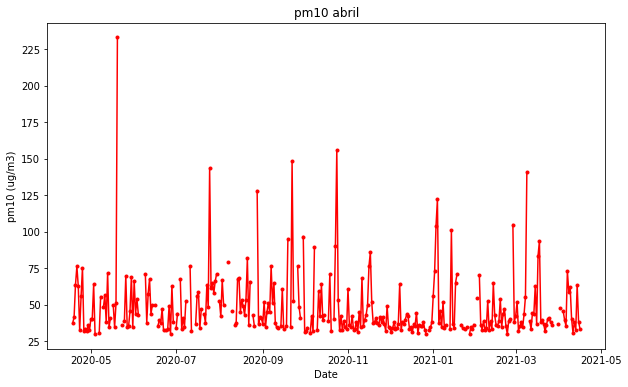

In [ ]:
df = df.groupby('time').median()
df = df.resample('24h').mean()
df = df.reset_index()
plt.figure(figsize=(10,6))
plt.xlabel('Date')
plt.ylabel('pm10 (ug/m3)')
plt.plot_date(df['time'], df['pm10'],linestyle ='solid', c='red', marker = '.')
plt.title('pm10 abril')
